In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
using Random

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future 

In [2]:
@model function rotate_ssm(n, θ, x0, Q::ConstVariable, P::ConstVariable)
    
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior ~ MvNormalMeanCovariance(mean(x0), cov(x0))
    
    x_prev = x_prior
    
    A = constvar([ cos(θ) -sin(θ); sin(θ) cos(θ) ])
    
    for i in 1:n
        x[i] ~ MvNormalMeanCovariance(A * x_prev, Q) where { q = q(out, mean)q(cov) }
        y[i] ~ MvNormalMeanCovariance(x[i], P) where { q = q(out)q(mean)q(cov) }
        
        x_prev = x[i]
    end
    
    return x, y
end

rotate_ssm (generic function with 1 method)

In [3]:
Random.seed!(1234)

θ = π / 8
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
Q = Matrix(Diagonal(1.0 * ones(2)))
P = Matrix(Diagonal(1.0 * ones(2)))

n = 325

x_prev = [ 10.0, -10.0 ]

x = Vector{Vector{Float64}}(undef, n)
y = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    x[i] = rand(MvNormal(A * x_prev, Q))
    y[i] = rand(MvNormal(x[i], Q))
    
    x_prev = x[i]
end

In [4]:
using Plots

In [5]:
slicedim(dim) = (a) -> map(e -> e[dim], a)

slicedim (generic function with 1 method)

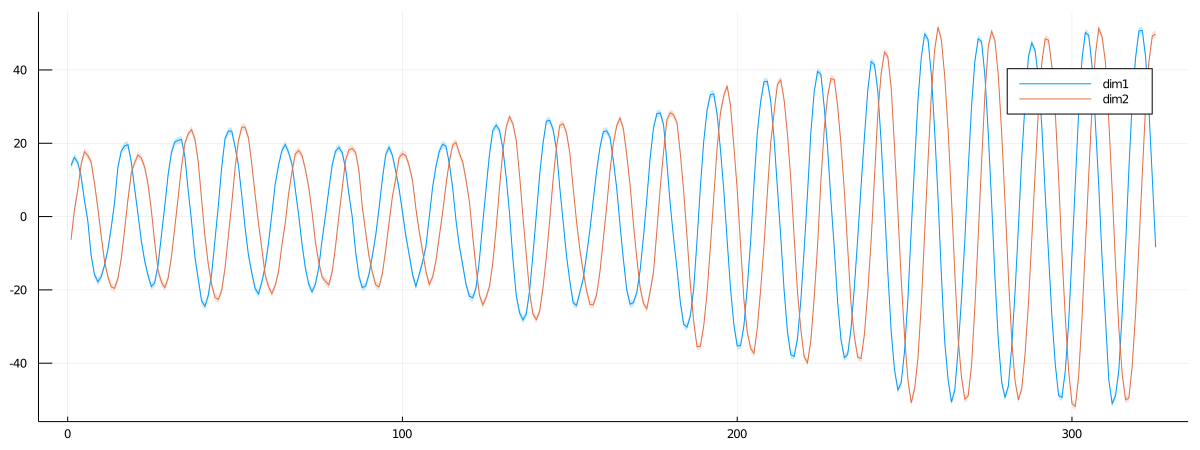

In [6]:
px = plot()

px = plot!(px, x |> slicedim(1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = :dim1)
px = plot!(px, x |> slicedim(2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = :dim2)

plot(px, size = (1200, 450))

In [7]:
function inference(observations, θ, x0)

    model, (x, y) = rotate_ssm(n, θ, x0, Q, P);

    ms_buffer = Vector{Marginal}(undef, n)
    fe_buffer = nothing
    
    marginals = collectLatest(getmarginals(x))

    fe_subscription = subscribe!(score(BetheFreeEnergy(), model, AsapScheduler()), (fe) -> fe_buffer = fe)
    ms_subscription = subscribe!(marginals, (ms) -> copyto!(ms_buffer, ms))
    
    update!(y, observations)

    unsubscribe!(ms_subscription)
    unsubscribe!(fe_subscription)
    
    return ms_buffer, fe_buffer
end

inference (generic function with 1 method)

In [8]:
function f(θ)
    x0 = MvNormalMeanCovariance([ θ[2], θ[3] ], Matrix(Diagonal(0.01 * ones(2))))
    xmarginals, fe = inference(y, θ[1], x0); 
    return fe
end

f (generic function with 1 method)

In [9]:
using Optim

In [10]:
res = optimize(f, zeros(3), LBFGS(), Optim.Options(f_tol = 1e-14, g_tol = 1e-12, show_trace = true))

Iter     Function value   Gradient norm 
     0     2.637147e+04     7.886246e+04
 * time: 0.004312992095947266
     1     2.041943e+04     6.301771e+04
 * time: 5.869725942611694
     2     1.586515e+04     3.669461e+04
 * time: 7.432794094085693
     3     1.240788e+04     4.994539e+03
 * time: 10.239784955978394
     4     1.235395e+04     1.443947e+01
 * time: 11.333527088165283
     5     1.235395e+04     6.660507e+00
 * time: 13.071705102920532
     6     1.229673e+04     2.161446e+02
 * time: 18.60553789138794
     7     1.229663e+04     2.565035e-01
 * time: 20.29924702644348
     8     1.229663e+04     2.933703e-01
 * time: 22.108975887298584
     9     1.229655e+04     3.508470e-02
 * time: 25.618319034576416
    10     1.229655e+04     1.038102e-07
 * time: 27.287379026412964
    11     1.229655e+04     8.616248e-08
 * time: 28.401977062225342
    12     1.229655e+04     5.138606e-08
 * time: 29.488828897476196


 * Status: success

 * Candidate solution
    Final objective value:     1.229655e+04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.13e-12 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.37e-15 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.46e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.18e-15 ≤ 1.0e-14
    |g(x)|                 = 5.14e-08 ≰ 1.0e-12

 * Work counters
    Seconds run:   29  (vs limit Inf)
    Iterations:    12
    f(x) calls:    52
    ∇f(x) calls:   52


In [11]:
println("Real value vs Optimized")
println("Real:      ", θ)
println("Optimized: ", res.minimizer)

Real value vs Optimized
Real:      0.39269908169872414
Optimized: [289.3632226989706, 10.662468432985698, -8.063805187126404]


In [12]:
@show sin(θ), sin(res.minimizer[1])
@show cos(θ), cos(res.minimizer[1])

(sin(θ), sin(res.minimizer[1])) = (0.3826834323650898, 0.3303728406318284)
(cos(θ), cos(res.minimizer[1])) = (0.9238795325112867, 0.9438505105009248)


(0.9238795325112867, 0.9438505105009248)

In [13]:
xmarginals, fe = inference(y, res.minimizer[1], MvNormalMeanCovariance([ res.minimizer[2], res.minimizer[3] ], Matrix(Diagonal(100.0 * ones(2)))));

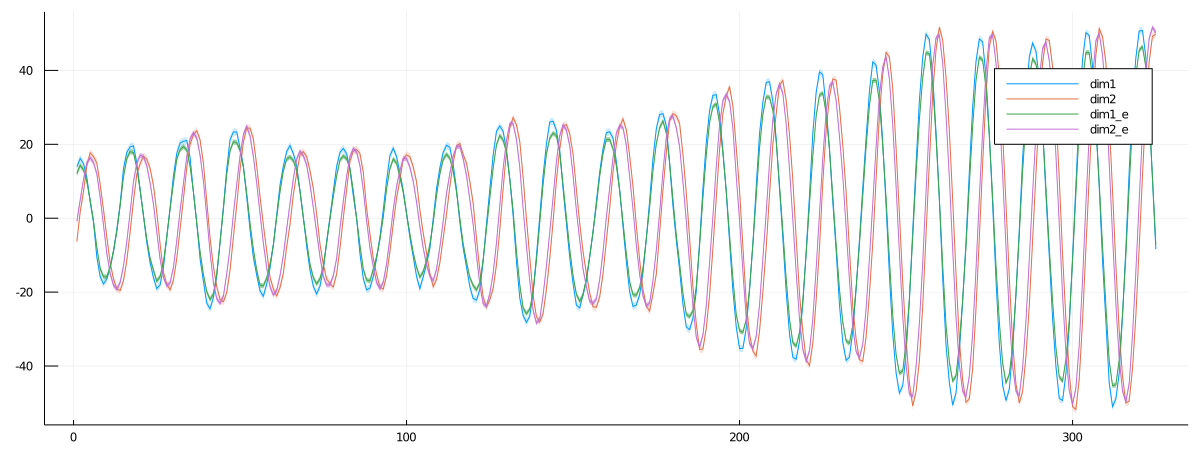

In [14]:
px = plot()

px = plot!(px, x |> slicedim(1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = :dim1)
px = plot!(px, x |> slicedim(2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = :dim2)
px = plot!(px, mean.(xmarginals) |> slicedim(1), ribbon = var.(xmarginals) |> slicedim(1) .|> sqrt, fillalpha = 0.5, label = :dim1_e)
px = plot!(px, mean.(xmarginals) |> slicedim(2), ribbon = var.(xmarginals) |> slicedim(2) .|> sqrt, fillalpha = 0.5, label = :dim2_e)

plot(px, size = (1200, 450))